In [1]:
# This file aimed to trined on a LSTM based on different power and threshould and
# see if it works.
from DataPrepocessing import *
from NeuralNets import *
from TrainMethod import *

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from functools import partial


(612, 833)


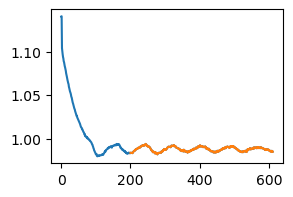

In [2]:
# read the data and only keep the stable state
plt.figure(figsize=(3,2))
raw_data_P1T1 = pd.read_csv("./data/Tracked Files/P1T1.csv")
raw_data_P1T1.fillna(0, inplace= True)
plt.plot(raw_data_P1T1.iloc[:,1])
cut_data_P1T1 = raw_data_P1T1[200:]
plt.plot(cut_data_P1T1.iloc[:,1])
print(raw_data_P1T1.shape)

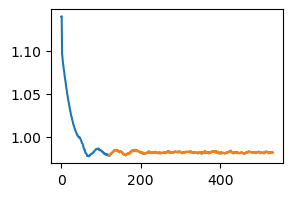

In [3]:
raw_data_P1T09 = pd.read_csv("./data/Tracked Files/P1T0.9.csv")
raw_data_P1T09.fillna(0, inplace= True)
plt.figure(figsize=(3,2))
data = raw_data_P1T09
plt.plot(data.iloc[:,1])
cut_data_P1T09 = data[120:]
plt.plot(cut_data_P1T09.iloc[:,1])

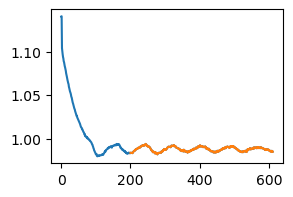

In [4]:
raw_data_P06T1 = pd.read_csv("./data/Tracked Files/P0.6T1.csv")
raw_data_P06T1.fillna(0, inplace= True)
plt.figure(figsize=(3,2))
plt.plot(raw_data_P06T1.iloc[:,1])
cut_data_P06T1 = raw_data_P06T1[200:]
plt.plot(cut_data_P06T1.iloc[:,1])

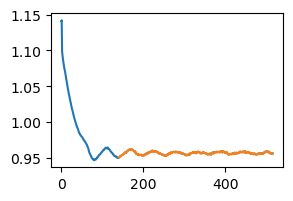

In [5]:
raw_data_P1T11 = pd.read_csv("./data/Tracked Files/P1T1.1.csv")
raw_data_P1T11.fillna(0, inplace= True)
plt.figure(figsize=(3,2))
plt.plot(raw_data_P1T11.iloc[:,1])
cut_data_P1T11 = raw_data_P1T11[140:]
plt.plot(cut_data_P1T11.iloc[:,1])

In [6]:
# now we get all the stable data
print(len(cut_data_P1T1))
print(len(cut_data_P1T11))
print(len(cut_data_P06T1))
print(len(cut_data_P1T09))

# first, cut the data according to the sequence length
sequence_length = 10

time_cut = lambda data : data[: len(data)//sequence_length * sequence_length]

cut_data_P1T11 = time_cut(cut_data_P1T11)
cut_data_P1T1 = time_cut(cut_data_P1T1)
cut_data_P06T1 = time_cut(cut_data_P06T1)
cut_data_P1T09 = time_cut(cut_data_P1T09)

print(len(cut_data_P1T1))
print(len(cut_data_P1T11))
print(len(cut_data_P06T1))
print(len(cut_data_P1T09))

412
376
412
413
410
370
410
410


In [7]:
# question: how to deal with non-fule pebbles?
# question: how to deal with NAN values i.e. different sample number each time stamp

all_data = pd.concat([cut_data_P1T1, cut_data_P1T11, cut_data_P06T1, cut_data_P1T09], ignore_index= True)
all_data.fillna(0, inplace= True)
print(all_data.shape)

(1600, 836)


In [8]:
# do the data preprossing
data = all_data.to_numpy()

# drop the first column
data = data[:, 1:]

data = standarlize(data)

clean_data = data.copy()


In [9]:
lables = data[:,0]
data = data[:,1:]
print(lables.shape)
print(data.shape)

(1600,)
(1600, 834)


In [11]:
training_data = ReactorData(data,lables,10,0,0.75)
testing_data = ReactorData(data,lables,10,0.75,1)

TypeError: __init__() takes from 2 to 5 positional arguments but 6 were given